In [1]:
import numpy as np
from matplotlib.pylab import *
import matplotlib.animation as animation

In [2]:
L = 10
N = L**2
NT = 10
Nsweeps = 1000
Nwarmup = 100
Nbins = 20
Temp = np.linspace(0.2,5,NT)

In [3]:
J = 1.0
B = 0.0

In [4]:
S = 2*np.random.randint(2,size=N)-1
S = S.reshape(L,L)
E = 0.0
M = 0
for i in range(L):
    for j in range(L):
        E -= J*S[i,j]*(S[(i+1)%L,j]+S[i,(j+1)%L])
        E -= B*S[i,j]
        M += S[i,j]
print(S)
print(np.shape(S))

[[ 1 -1 -1  1  1 -1 -1 -1  1  1]
 [ 1 -1 -1  1  1 -1  1  1 -1 -1]
 [-1  1  1 -1  1  1  1 -1 -1  1]
 [-1 -1 -1 -1  1  1  1 -1  1  1]
 [-1  1 -1  1  1  1  1 -1 -1 -1]
 [-1 -1  1 -1 -1  1  1 -1 -1 -1]
 [-1  1  1  1  1  1 -1 -1  1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1  1]
 [ 1  1 -1 -1  1  1 -1 -1 -1 -1]
 [-1 -1 -1 -1  1  1  1  1 -1  1]]
(10, 10)


In [5]:
E_avg = np.zeros(NT)
E2_avg = np.zeros(NT)
M_avg = np.zeros(NT)
M2_avg = np.zeros(NT)
X = np.zeros([Nsweeps, N], int)

# I start from high T and work my way to lower T
k = 0
for iT in range(NT):
    T = Temp[iT]
    
    # These are the warmup sweeps
    for iswp in range(Nwarmup):
        for isite in range(N):
            i = np.random.randint(L)
            j = np.random.randint(L)
            dE = 2*J*S[i,j]*(S[(i+1)%L,j]+S[i,(j+1)%L]+S[(i-1)%L,j]+S[i,(j-1)%L])
            r = np.random.random()
            if r < np.exp(-dE/T):
                S[i,j] *= -1
                E += dE
                M += 2*S[i,j]
                
    # Important to zero bin averages for a new T
    E_bin = np.zeros(Nbins)
    M_bin = np.zeros(Nbins)
    
    # This is the measurement loop
    # Every bin holds the average of Nsweeps/Nbins consequetive sweeps
    for ib in range(Nbins):
        for iswp in range(Nsweeps//Nbins):
            for isite in range(N):
                i = np.random.randint(L)
                j = np.random.randint(L)
                dE = 2*J*S[i,j]*(S[(i+1)%L,j]+S[i,(j+1)%L]+S[(i-1)%L,j]+S[i,(j-1)%L])
                r = np.random.random()
                if r < np.exp(-dE/T):
                    S[i,j] *= -1
                    
                    # Keeping track of the energy and magnetization
                    E += dE
                    M += 2*S[i,j]
                    
            E_bin[ib] += E
            M_bin[ib] += M
            
            # Perhaps not the best implementation, but here is
            # where I keep one out of every 10 sweeps (100 configurations
            # per temperature)
            if iswp % NT == 0:
                X[k] = S.reshape(N)
                k += 1
        # Averaging the bin averages    
        E_avg[iT]  +=  E_bin[ib]/Nsweeps*Nbins
        E2_avg[iT] += (E_bin[ib]/Nsweeps*Nbins)**2
        M_avg[iT]  +=  M_bin[ib]/Nsweeps*Nbins
        M2_avg[iT] += (M_bin[ib]/Nsweeps*Nbins)**2

    E_avg[iT]  /= Nbins
    E2_avg[iT] /= Nbins
    M_avg[iT]  /= Nbins
    M2_avg[iT] /= Nbins

    # Standard errors for Gaussian distributed data
    errorE = np.sqrt(E2_avg[iT]-E_avg[iT]**2)/np.sqrt(Nbins-1)
    errorM = np.sqrt(M2_avg[iT]-M_avg[iT]**2)/np.sqrt(Nbins-1)

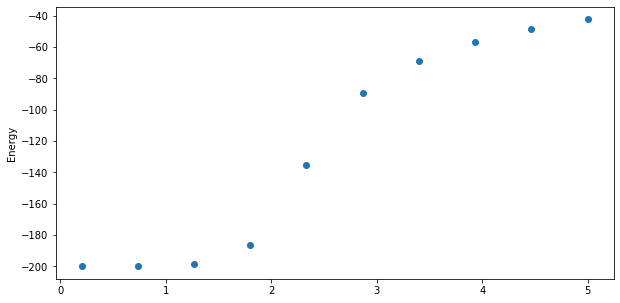

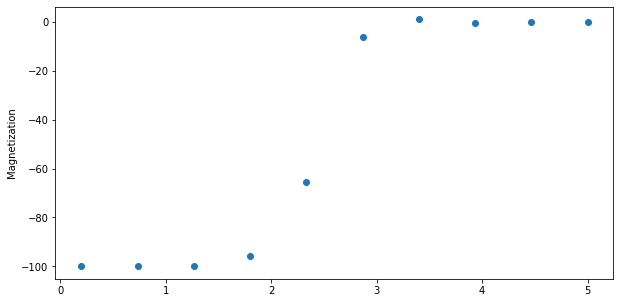

In [6]:
plt.figure(figsize=[10,5])
plt.scatter(Temp, E_avg)
plt.ylabel('Energy')
plt.figure(figsize=[10,5])
plt.ylabel('Magnetization')
plt.scatter(Temp, M_avg)

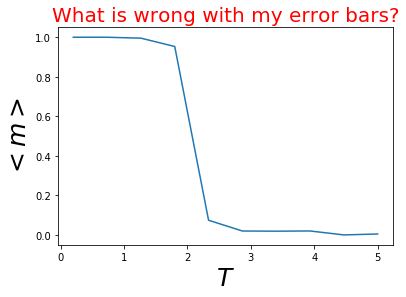

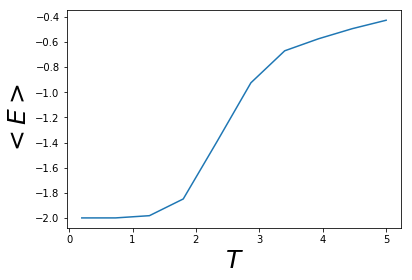

In [11]:
errorbar(Temp,np.abs(M_avg)/N,yerr=errorM/N)
xlabel('$T$', fontsize=25)
ylabel('$<m>$', fontsize=25)
title('What is wrong with my error bars?' , fontsize=20, color='r')
show()

errorbar(Temp,E_avg/N,yerr=errorE/N)
xlabel('$T$', fontsize=25)
ylabel('$<E>$', fontsize=25)
show()

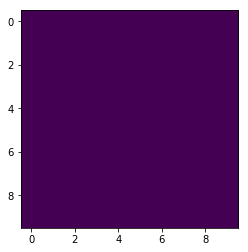

In [10]:
# These two boxes are for the animation, using one out of every 10
# configurations (total of 100 frames)
fig1 = figure()
ax = fig1.add_subplot(111)
anim = []
for i in range(0,Nsweeps,10):
    anim.append([imshow(X[i].reshape(L,L), interpolation=None)])

In [9]:
im = animation.ArtistAnimation(fig1, anim) #, interval=200, repeat_delay=300,blit=True)

plt.rcParams['animation.html'] = 'html5'
# For some, the following line works instead:
#plt.rcParams['animation.html'] = 'jshtml'